# Gapminder Dataset Analysis

In [78]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.offline as pyo
from IPython.display import IFrame
from IPython.display import Markdown as md

from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [3]:
# read in data
df = pd.read_csv('gapminder_clean.csv', index_col=0)

#rename the columns
df.columns = ("country", "year", "agriculture_value_added",
    "co2_emissions", "domestic_credit_by_financial_sector",
    "electric_power_consumption", "energy_use", "exports",
    "fertility_rate", "GDP_growth", "imports",
    "industry_value_added", "inflation", "life_expectancy",
    "population_density", "services_value_added", "population",
    "continent", "GDP_per_cap")
df.head()

,country,year,agriculture_value_added,co2_emissions,domestic_credit_by_financial_sector,electric_power_consumption,energy_use,exports,fertility_rate,GDP_growth,imports,industry_value_added,inflation,life_expectancy,population_density,services_value_added,population,continent,GDP_per_cap
0,Afghanistan,1962,NaN,0.073781,21.276422,NaN,NaN,4.878051,7.450,NaN,9.349593,NaN,NaN,33.219902,14.312061,NaN,10267083.0,Asia,853.100710
1,Afghanistan,1967,NaN,0.123782,9.917662,NaN,NaN,6.772908,7.450,NaN,14.209827,NaN,NaN,35.389415,15.881812,NaN,11537966.0,Asia,836.197138
2,Afghanistan,1972,NaN,0.130820,18.880833,NaN,NaN,14.763231,7.450,NaN,18.105850,NaN,NaN,37.610146,17.947027,NaN,13079460.0,Asia,739.981106
3,Afghanistan,1977,NaN,0.183118,13.836822,NaN,NaN,11.662904,7.449,NaN,14.823175,NaN,NaN,40.110146,19.998926,NaN,14880372.0,Asia,786.113360
4,Afghanistan,1982,NaN,0.165879,NaN,NaN,NaN,NaN,7.450,NaN,NaN,NaN,NaN,43.230732,19.402324,NaN,12881816.0,Asia,978.011439


### CO2 Emissions Versus GDP Per Capita In 1962

In [5]:
#filter to include only rows where the year is 1962 and remove any rows with missing values
co2_GDP_1962 = df[df['year'] == 1962][['co2_emissions', 'GDP_per_cap']].dropna()

In [7]:
# check normality with histograms
fig = sp.make_subplots(rows=1, cols=2,
                    subplot_titles=("CO2 Emissions in 1962", "GDP Per Capita in 1962"))
fig.add_trace(go.Histogram(x=co2_GDP_1962['co2_emissions'], name='CO2 Emissions'), row=1, col=1)
fig.add_trace(go.Histogram(x=co2_GDP_1962['GDP_per_cap'], name='GDP Per Capita'), row=1, col=2)
fig.update_layout(height=600, width=800, title_text="Histograms For Checking Normality", showlegend=False)
pyo.plot(fig, filename='histograms_1962.html', auto_open=False)
IFrame(src='histograms_1962.html', width=800, height=600)

In [8]:
# Spearman correlation
corr_1962, p_val_1962 = stats.spearmanr(co2_GDP_1962['co2_emissions'], co2_GDP_1962['GDP_per_cap'])
rho_1962 = round(corr_1962, 2)
p_val_1962_sci = "{:.2e}".format(p_val_1962)

In [10]:
md(f"""
Data was not normally distributed so Spearman's correlation was used to 
look at the relationship between CO2 emissions and GDP per capita in 1962. The 
correlation coefficient was {rho_1962} with a p-value of {p_val_1962_sci}.
""")


Data was not normally distributed so Spearman's correlation was used to 
look at the relationship between CO2 emissions and GDP per capita in 1962. The 
correlation coefficient was 0.85 with a p-value of 8.34e-32.


In [12]:
fig = px.scatter(co2_GDP_1962, x='GDP_per_cap', y='co2_emissions',
                 trendline="ols", log_x=True, log_y=True)

# For x-axis
x_tickvals = pd.to_numeric(
    [f"{n:.1g}" for n in np.geomspace(1, co2_GDP_1962['GDP_per_cap'].max(), 15)]
)

# For y-axis
y_tickvals = pd.to_numeric(
    [f"{n:.1g}" for n in np.geomspace(0.01, co2_GDP_1962['co2_emissions'].max()*2, 8)]
)

fig.update_layout(
    title="CO2 Emissions Versus GDP Per Capita in 1962",
    xaxis=dict(
        title="GDP per capita",
        tickmode = 'array',
        tickvals = x_tickvals
    ),
    yaxis=dict(
        title="CO2 emissions (metric tons per capita)",
        tickmode = 'array',
        tickvals = y_tickvals
    ),
    annotations=[
        go.layout.Annotation(
            x=np.log10(1000),
            y=np.log10(200),
            text=f"R = {rho_1962}",
            showarrow=False,
        ),
        go.layout.Annotation(
            x=np.log10(1000),
            y=np.log10(100),
            text=f"p-value = {p_val_1962_sci}",
            showarrow=False,
        )
    ]
)
pyo.plot(fig, filename='scatterplot_1962.html', auto_open=False)
IFrame(src='scatterplot_1962.html', width=800, height=600)

### CO2 Emissions Versus GDP Per Capita For All Years

In [14]:
# check normality
fig1 = go.Histogram(x=df['co2_emissions'], nbinsx=50, name='CO2 Emissions')
layout1 = go.Layout(xaxis=dict(title="CO2 Emissions"), yaxis=dict(title="Count"))

fig2 = go.Histogram(x=df['GDP_per_cap'], nbinsx=50, name='GDP Per Capita')
layout2 = go.Layout(xaxis=dict(title="GDP Per Capita"), yaxis=dict(title="Count"))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('CO2 Emissions', 'GDP Per Capita'))
fig.add_trace(fig1, 1, 1)
fig.add_trace(fig2, 1, 2)

fig['layout'].update(height=600, width=800, title="Histograms For Checking Normality", showlegend=False)

pyo.plot(fig, filename='histogram_all_years.html', auto_open=False)
IFrame(src='histogram_all_years.html', width=800, height=600)

In [15]:
# Remove rows with NA values
co2_gdp_corr = df[['year', 'co2_emissions', 'GDP_per_cap']].dropna()

# Group by year and calculate correlation
co2_gdp_corr = co2_gdp_corr.groupby('year').apply(
    lambda x: stats.spearmanr(x['co2_emissions'], x['GDP_per_cap'])[0]
).reset_index().rename(columns={0: 'correlation'})

# Create plotly line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=co2_gdp_corr['year'], 
    y=co2_gdp_corr['correlation'],
    mode='lines+markers',
    name='lines+markers'
))

fig.update_xaxes(
    tickvals=list(range(1960, 2011, 5)),
    ticktext=list(range(1960, 2011, 5))
)

fig.update_layout(
    title="Correlation Between CO2 Emissions and GDP",
    xaxis_title="Year",
    yaxis_title="Spearman Correlation Between CO2 Emissions and GDP",
)

pyo.plot(fig, filename='correlation_all_years.html', auto_open=False)
IFrame(src='correlation_all_years.html', width=800, height=600)

In [16]:
max_corr_year = co2_gdp_corr[co2_gdp_corr['correlation'] == co2_gdp_corr['correlation'].max()]['year']
max_corr_year = max_corr_year.values[0]

In [19]:
md(f"""
Data was not normally distributed so a Spearman's correlation was used. 
Correlation between CO2 emissions and GDP per capita was highest in {max_corr_year}.
""")


Data was not normally distributed so a Spearman's correlation was used. 
Correlation between CO2 emissions and GDP per capita was highest in 2002.


In [53]:
md(f"### CO2 Emissions Versus GDP Per Capita In {max_corr_year}")

### CO2 Emissions Versus GDP Per Capita In 2002

In [21]:
# Filter data from the year with max correlation
data_from_max_year = df[df['year'] == max_corr_year][['co2_emissions', 'GDP_per_cap', 'population', 'continent']].dropna()

# Create a plotly scatter plot
fig = px.scatter(data_from_max_year, x='GDP_per_cap', y='co2_emissions', 
                 size='population', color='continent', log_x=True, log_y=True,
                 size_max=50)


# Update layout and labels
fig.update_layout(
    title=f"CO2 Emissions vs GDP Per Capita in {max_corr_year}",
    xaxis_title="GDP per capita",
    yaxis_title="CO2 emissions (metric tons per capita)",
    legend_title="Continent",
    xaxis={
        "tickmode": "array",
        "tickvals": pd.to_numeric(
            [f"{n:.1g}" for n in np.geomspace(1, data_from_max_year['GDP_per_cap'].max(), 15)]
        ),
    },
    yaxis={
        "tickmode": "array",
        "tickvals": pd.to_numeric(
            [f"{n:.1g}" for n in np.geomspace(0.1, data_from_max_year['co2_emissions'].max()*2, 6)]
        ),
    },
    )

pyo.plot(fig, filename='co2_gdp_population.html', auto_open=False)
IFrame(src='co2_gdp_population.html', width=800, height=600)

### Energy Use By Continent
Before comparing energy use in different continents, a quantile-quantile 
plot was used to check the normality of energy use data.

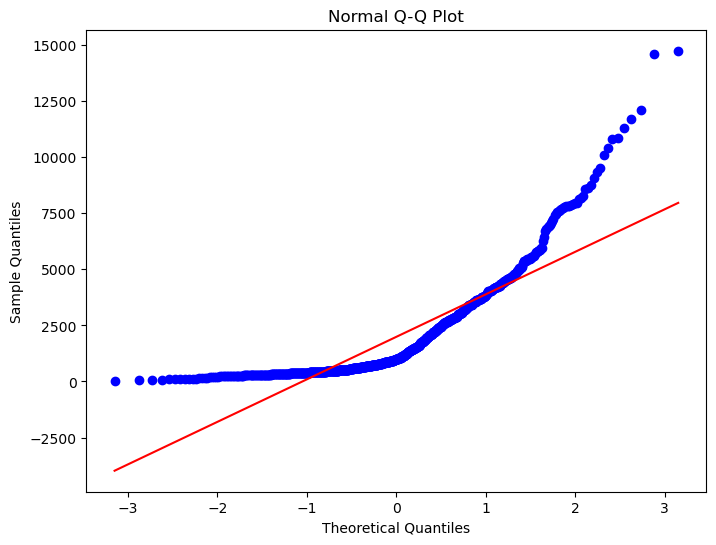

In [23]:
# Filter and clean data
continent_energy_df = df[['energy_use', 'continent']].dropna()

# Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(continent_energy_df['energy_use'], dist="norm", plot=plt)

plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

Because the data was not normally distributed, a Kruskal-Wallis test was used to
check for a significant difference between continents. Then, a Mann-Whitney U test 
with Bonferri correction was performed.

In [49]:
# Filter and clean data
continent_energy_df = df[['energy_use', 'continent']].dropna()

# Perform Kruskal-Wallis test
stat, p = stats.kruskal(*[group["energy_use"].values for name, group in continent_energy_df.groupby("continent")])
stat_rounded = "{:.2f}".format(stat)
p_val_rounded = "{:.2e}".format(p)

md(f"""
#### Kruskal-Wallis Test
\nStatistic:", {stat_rounded} 
\np-value:", "{p_val_rounded} 
""")


#### Kruskal-Wallis Test

Statistic:", 318.68 

p-value:", "1.01e-67 


In [81]:
md(f"#### Mann-Whitney U Test with Bonferri Correction")

#### Mann-Whitney U Test with Bonferri Correction

In [82]:
# Perform pairwise Mann-Whitney U tests
continents = continent_energy_df['continent'].unique()

p_values = []
comparisons = []
for i in range(len(continents)):
    for j in range(i+1, len(continents)):
        group1 = continent_energy_df[continent_energy_df['continent'] == continents[i]]['energy_use']
        group2 = continent_energy_df[continent_energy_df['continent'] == continents[j]]['energy_use']
        stat, p = mannwhitneyu(group1, group2)
        p_values.append(p)
        comparisons.append(f"{continents[i]} vs {continents[j]}")

# Apply Bonferroni correction
reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

# function for getting p-values in scientific notation with 2 decimal places
def format_p_value(p):
    return "{:.2e}".format(p)

# Combine the results into a DataFrame
results = pd.DataFrame({'Comparison': comparisons, 'p-value': corrected_p_values, 'Reject H0': reject})
results['p-value'] = results['p-value'].apply(format_p_value)
results

,Comparison,p-value,Reject H0
0,Europe vs Africa,1.48e-57,True
1,Europe vs Americas,2.52e-28,True
2,Europe vs Oceania,3.82e-02,True
3,Europe vs Asia,1.95e-22,True
4,Africa vs Americas,7.75e-14,True
5,Africa vs Oceania,5.61e-12,True
6,Africa vs Asia,1.28e-03,True
7,Americas vs Oceania,5.64e-07,True
8,Americas vs Asia,9.75e-01,False
9,Oceania vs Asia,2.47e-06,True


There were significant differences in energy use between continents, with 
Oceania having the highest consumption per capita.

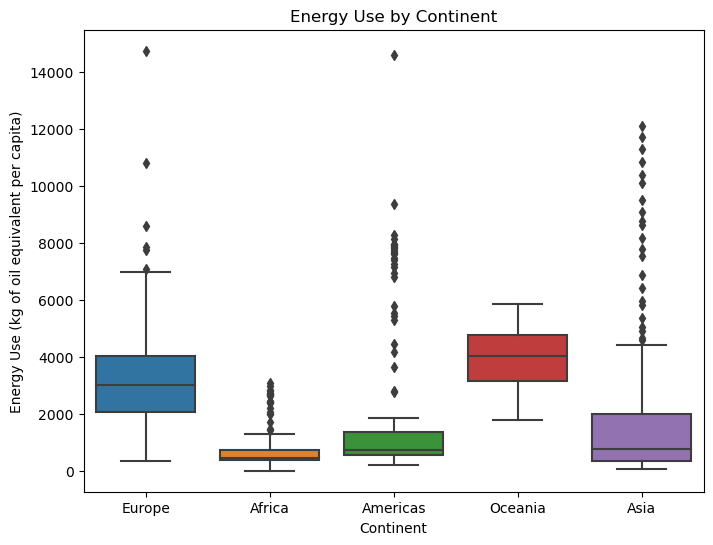

In [29]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='continent', y='energy_use', data=continent_energy_df)

plt.title('Energy Use by Continent')
plt.ylabel('Energy Use (kg of oil equivalent per capita)')
plt.xlabel('Continent')
plt.show()

### Imports In Europe & Asia After 1990
A quantile-quantile plot was used to check the normality of imports data
in Europe and Asia after 1990.

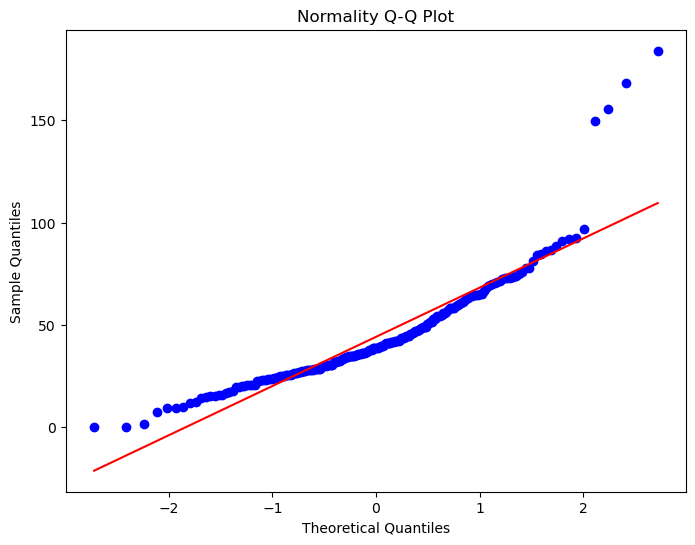

In [48]:
# Filter and clean data
imports_eu_asia = df[(df['continent'].isin(['Europe', 'Asia'])) & (df['year'] > 1990)][['continent', 'year', 'imports']].dropna()

# Q-Q plot for checking normality
plt.figure(figsize=(8, 6))
stats.probplot(imports_eu_asia['imports'], plot=plt)
plt.title('Normality Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(imports_eu_asia['imports'])
import_normality_p_val = "{:.2e}".format(p)

In [72]:
md(f"""
Shapiro-Wilk test was also used. The p-value was {import_normality_p_val} 
which is less than 0.05 which means that the data is not normally distributed.
Therefore, a Wilcoxon rank-sum test was used compare imports between Europe 
and Asia.
""")


Shapiro-Wilk test was also used. The p-value was 1.46e-13 
which is less than 0.05 which means that the data is not normally distributed.
Therefore, a Wilcoxon rank-sum test was used compare imports between Europe 
and Asia.


For year 2002, p-value for Wilcoxon rank sum test was 0.90
For year 2007, p-value for Wilcoxon rank sum test was 0.39
For year 1992, p-value for Wilcoxon rank sum test was 0.48
For year 1997, p-value for Wilcoxon rank sum test was 0.33


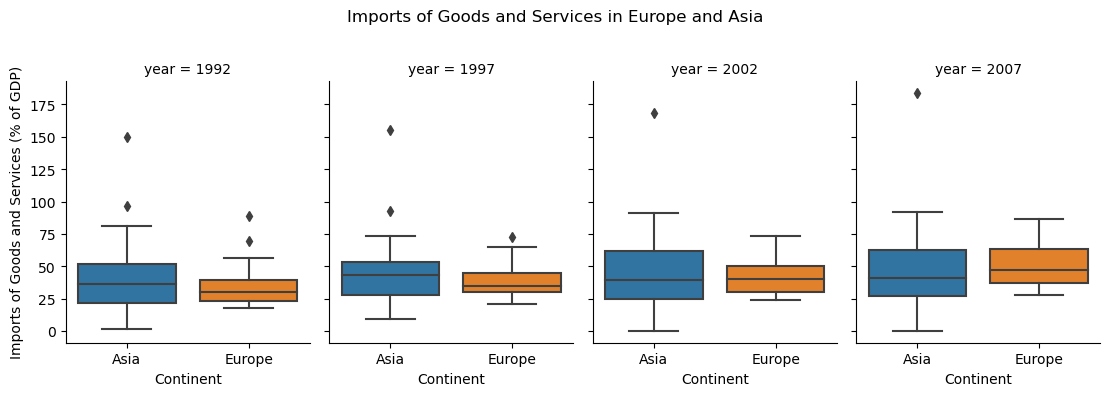

In [70]:
# Make sure year is treated as categorical
imports_eu_asia['year'] = imports_eu_asia['year'].astype('category')

# Generate faceted boxplot
p = sns.catplot(data=imports_eu_asia, x='continent', y='imports', col='year', kind='box', height=4, aspect=0.7)
p.set_axis_labels("Continent", "Imports of Goods and Services (% of GDP)")
p.fig.subplots_adjust(top=0.8)  # adjust the Figure in rp
p.fig.suptitle('Imports of Goods and Services in Europe and Asia')

# Perform Wilcoxon rank sum test for each year and print results
for year in imports_eu_asia['year'].unique():
    europe_imports = imports_eu_asia[(imports_eu_asia['continent'] == 'Europe') & (imports_eu_asia['year'] == year)]['imports']
    asia_imports = imports_eu_asia[(imports_eu_asia['continent'] == 'Asia') & (imports_eu_asia['year'] == year)]['imports']
    stat, p = stats.ranksums(europe_imports, asia_imports)
    print(f"For year {year}, p-value for Wilcoxon rank sum test was {p:.2f}")

There was no significant difference between Europe and Asia (p>0.05) 
with respect to the percentage of GDP that accounts for imports of
goods and services in any years since 1990.

### Countries With High Population Density

This table shows the top 5 countries with the highest average ranking in 
population density across all time points.

In [75]:
# Add a column with the rank of population density for each year
df['pop_density_rank'] = df.groupby('year')['population_density'].rank(method='min')

# Calculate the mean rank for each country
pop_density_ranking = df.groupby('country')['pop_density_rank'].mean().reset_index()

# Sort the dataframe based on the mean rank and select the top 5 countries
top_5_pop_density_countries = pop_density_ranking.sort_values('pop_density_rank', ascending=False).head(5).reset_index(drop=True)
top_5_pop_density_countries.columns = ['Country', 'Average Ranking of Population Density']
top_5_pop_density_countries

,Country,Average Ranking of Population Density
0,Monaco,255.3
1,"Macao SAR, China",255.3
2,"Hong Kong SAR, China",253.7
3,Singapore,252.9
4,Sint Maarten (Dutch part),252.5


In [76]:
md(f"""
The two countries with the highest average ranking in population density were
{top_5_pop_density_countries.Country[1]} and {top_5_pop_density_countries.Country[2]}.
""")


The two countries with the highest average ranking in population density were
Macao SAR, China and Hong Kong SAR, China.


### Countries With The Greatest Increase In Life Expectancy

The table below shows countries with the greatest incresease in life expectancy
since 1962.

In [77]:
# Select the rows for the years 1962 and 2007
life_exp_1962 = df.loc[df['year'] == 1962, ['country', 'life_expectancy']]
life_exp_2007 = df.loc[df['year'] == 2007, ['country', 'life_expectancy']]

# Rename the life_expectancy columns
life_exp_1962.rename(columns={'life_expectancy': 'life_exp_1962'}, inplace=True)
life_exp_2007.rename(columns={'life_expectancy': 'life_exp_2007'}, inplace=True)

# Merge the two dataframes
merged = pd.merge(life_exp_1962, life_exp_2007, on='country')

# Calculate the difference between life expectancy in 2007 and 1962
merged['life_expectancy_diff'] = merged['life_exp_2007'] - merged['life_exp_1962']

# Sort the dataframe based on the difference and select the top 5 countries
top_life_exp_diff = merged.sort_values('life_expectancy_diff', ascending=False).head(5).reset_index(drop=True).round(2)
top_life_exp_diff.columns = ['Country', 'Life Expectancy in 1962', 'Life Expectancy in 2007', 'Difference in Life Expectancy (Years)']
top_life_exp_diff

,Country,Life Expectancy in 1962,Life Expectancy in 2007,Difference in Life Expectancy (Years)
0,Maldives,38.48,75.40,36.92
1,Bhutan,33.09,66.29,33.20
2,Timor-Leste,34.74,65.82,31.09
3,Tunisia,43.34,74.20,30.86
4,Oman,44.30,75.12,30.82
